# 13. INTRODUCTION DEEP LEARNING

# 13.5. Dropout and Batch Normalization

# 13.5.1. COURS

In [1]:
# Chemin des sources
import os
os.chdir('C:/Users/PC Maison/4-KAGGLE/KAGGLE_DEV/KAGGLE_COURS_13-INTRO_DEEP_LEARNING/input')

In [2]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

red_wine = pd.read_csv('red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


# Example - Using Dropout and Batch Normalization

In [4]:
# Pour ajouter des abandons, vous devrez peut-être augmenter le nombre d'unités
# dans vos couches Dense.

from tensorflow import keras
from tensorflow.keras import layers, callbacks

model = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1),
])

In [5]:
model.compile(
    optimizer='adam',
    loss='mae',
)

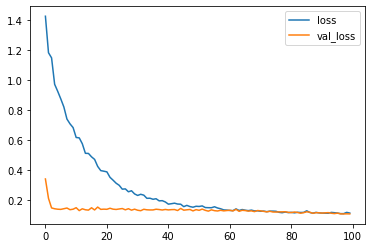

In [6]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=100,
    verbose=0,
)


# Show the learning curves
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
# Vous obtiendrez généralement de meilleures performances si vous normalisez 
# vos données avant de les utiliser pour la formation. Le fait que nous ayons 
# pu utiliser les données brutes montre cependant à quel point la normalisation
# par lots peut être efficace sur des ensembles de données plus difficiles.

# 13.5.2. EXERCICES

In [7]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

In [12]:
X = spotify.copy().dropna()

In [13]:
y = X.pop('track_popularity')

In [14]:
artists = X['track_artist']

In [15]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [16]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [17]:
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [18]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [19]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

In [20]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


# 1) Add Dropout to Spotify Model

In [21]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1)
])

In [22]:
model.compile(
    optimizer='adam',
    loss='mae',
)

Minimum Validation Loss: 0.1905


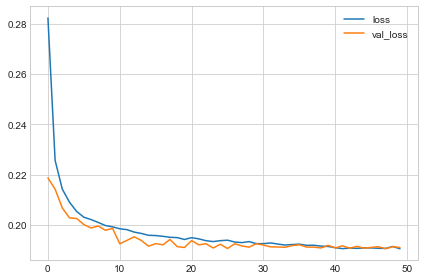

In [23]:
#  entraîner le modèle et voir l'effet de l'ajout de l'abandon.
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

# 2) Evaluate Dropout

In [ ]:
# D'après les courbes d'apprentissage, vous pouvez voir que la perte de 
# validation reste proche d'un minimum constant même si la perte de formation 
# continue à diminuer. Nous pouvons donc voir que l'ajout d'abandons a permis 
# d'éviter le surclassement cette fois-ci. De plus, en rendant plus difficile 
# pour le réseau de s'adapter à des modèles erronés, l'abandon peut avoir 
# encouragé le réseau à rechercher davantage les modèles réels, améliorant 
# peut-être aussi la perte de validation).

In [24]:
import pandas as pd

concrete = pd.read_csv('concrete.csv')
df = concrete.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = df_train.drop('CompressiveStrength', axis=1)
X_valid = df_valid.drop('CompressiveStrength', axis=1)
y_train = df_train['CompressiveStrength']
y_valid = df_valid['CompressiveStrength']

input_shape = [X_train.shape[1]]

Minimum Validation Loss: nan


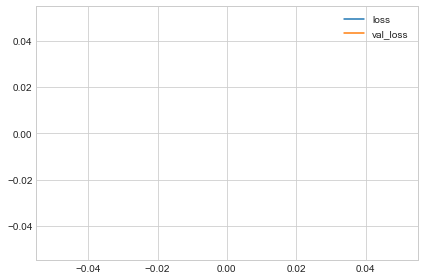

In [25]:
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.Dense(512, activation='relu'),    
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])
model.compile(
    optimizer='sgd', # SGD is more sensitive to differences of scale
    loss='mae',
    metrics=['mae'],
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=100,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

In [ ]:
# Vous êtes-vous retrouvé avec un graphique vierge ? Essayer de former ce 
# réseau sur cet ensemble de données échoue généralement. Même lorsqu'il
# converge (en raison d'une initialisation de poids chanceux), il a tendance à 
# converger vers un très grand nombre.

# 3) Add Batch Normalization Layers

In [26]:
# YOUR CODE HERE: Add a BatchNormalization layer before each Dense layer
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1),
])

In [27]:
model.compile(
    optimizer='sgd',
    loss='mae',
    metrics=['mae'],
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Minimum Validation Loss: 3.8363


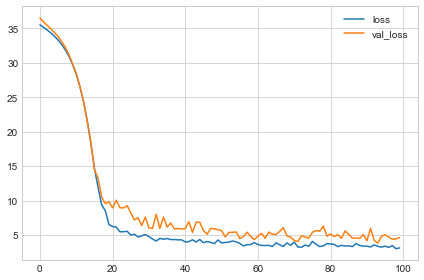

In [28]:
EPOCHS = 100
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=64,
    epochs=EPOCHS,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

# 4) Evaluate Batch Normalization

In [30]:
# Vous pouvez voir que l'ajout de la normalisation par lots a été une grande 
# amélioration par rapport à la première tentative ! En adaptant l'échelle des 
# données lors de leur passage sur le réseau, la normalisation par lots peut 
# vous permettre de former des modèles sur des ensembles de données difficiles.